# Acoustic radiation force on two & three sound-hard spheres

### Arnold D. Kim
*Department of Applied Mathematics, University of California, Merced*

### Nicholas St. Clair
*Department of Physics, University of California, Merced*

In [1]:
import  time
print( 'Last updated: %s' %time.strftime('%d/%m/%Y') )

Last updated: 13/08/2021


In [2]:
# defaults for the codes below

import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

## 1 Problem description

NEEDS UPDATING

We compute the solution of the scattering problem for the scalar potential, $\phi_{1}$:
\begin{gather*}
   \varDelta \phi_{1} + k^{2} \phi_{1} = 0, \quad \text{in $r > a$},\\
   \partial_{r} \phi_{1} = 0 \quad \text{on $r = a$}.
\end{gather*}
The incident field is given by a plane wave,
\begin{equation}
   \phi_{1}^{\text{inc}} = e^{\mathrm{i} k z}.
\end{equation}

We solve this scattering problem using two methods. The first uses the analytical representation as an expansion in Legendre polynomials. The second method uses the method of fundamental solutions (MFS). Through a comparison of these two results, we validate the use of the MFS to solve this problem.

Using the results from this scattering problem, we compute the acoustic radiation force defined according to (see Eq. (10) of H. Bruus, "Acoustofluidics 7: The acoustic radiation force on small particles," Lab Chip **12**, 1014 -- 1021 (2012))
\begin{equation}
   \vec{F} = -\int_{\partial \Omega} \left\{ \left[ \frac{1}{2} \kappa_{0} \langle p_{1}^{2} \rangle
   - \frac{1}{2} \rho_{0} \langle v_{1}^{2} \rangle \right] \hat{n} + \rho_{0} \langle ( \hat{n} \cdot \vec{v}_{1} ) 
   \vec{v}_{1} \rangle \right\} \mathrm{d}S.
\end{equation}
Here $p_{1}$ is the pressure field defined according to
\begin{equation}
   p_{1} = \mathrm{i} \rho_{0} \omega \phi_{1}
\end{equation}
$v_{1}$ is the velocity field defined according to
\begin{equation}
   v_{1} = \nabla \phi_{1},
\end{equation}
and the notation $\langle \cdot \rangle$ denotes a time-averaging operation.

Note that due to the sound-hard assumption, $\hat{n} \cdot \vec{v}_{1} = 0$ identically. Therefore, this expression for the force reduces to
\begin{equation}
   \vec{F} = -\int_{\partial \Omega} \left\{ \left[ \frac{1}{2} \kappa_{0} \langle p_{1}^{2} \rangle
   - \frac{1}{2} \rho_{0} \langle v_{1}^{2} \rangle \right] \hat{n} \right\} \mathrm{d}S.
\end{equation}

## 2 The Method of Fundamental Solutions (MFS)

Here, we compute the solution of the scattering problem using the Method of Fundamental Solutions (MFS).

### 2.1 Compute the MFS points

We compute the Fibonnaci lattice (see A. Gonzalez, "Measurement of areas using Fibonnaci and latitude-longitude lattices," Math. Geosci. **42**, 49 (2010)) and use the resulting points on the sphere for the MFS.

In [3]:
def ComputeMFSReferencePoints( a, N ):
    """
    This function computes the set of points for a reference sphere that is to be used in the method of 
    fundamental solutions (MFS).
    
    In particular, given the radius of a sphere, a, and the number of points N, this function computes 
    randomly distributed points on the unit sphere and stores them as the unit normal vectors ν. Using 
    ν, we then compute ρ_bdy = a * ν, and ρ_src = ( a - ℓ ) * ν.
    
    This function outputs three vectors: ν, ρ_bdy, and ρ_src.
    """
    # allocate memory for the Fibonacci lattice points on the unit sphere

    ν = np.full( ( N, 3 ), float( 'nan' ) )

    # compute the "golden angle"

    golden_angle = np.pi * ( 3.0 - np.sqrt( 5.0 ) )

    # compute the points on the unit sphere

    ν[:,2] = ( 1 - 1 / N ) * ( 1 - 2 * np.arange( 0, N ) / ( N - 1 ) )

    ρ = np.sqrt( 1.0 - ν[:,2] ** 2 )
    θ = golden_angle * np.arange( 0, N )

    ν[:,0] = ρ * np.cos( θ )
    ν[:,1] = ρ * np.sin( θ )

    # compute the boundary points, interior points, and exterior points

    ℓ = 0.4 * a

    ρ_bdy = a * ν
    ρ_src = ( a - ℓ ) * ν
    
    return ν, ρ_bdy, ρ_src;

It would be interesting to see if $l$ has any effect on the double body simulation.

### 2.2 Compute the fundamental solution and its normal derivative

The functions below compute Green's function in a medium with wavenumber $k$ and its normal derivative.

In [4]:
# function to compute Green's function

def ComputeG( k, R ):
    """
    This function computes the whole space Green's function given a wavenumber k and a distance R.
    
    The output of this function is the evaluation of the whole space Green's function.
    """
    
    # compute Green's function
    
    G = np.exp( 1j * k * R ) / ( 4 * np.pi * R )
      
    return G;

# function to compute the normal derivative of Green's function

def ComputeDνG( k, R, CosΘ ):
    """
    This function computes the normal derivative of the whole space Green's function 
    given a wavenumber k and distance R, and the cosine of the angle made between the 
    difference vector and the unit normal.
    
    The output of this function is the evaluation of the normal derivative of the whole 
    space Green's function.
    """
    
    # compute Green's function
    
    G = ComputeG( k, R )
    
    # compute the normal derivative of Green's function
    
    DνG = CosΘ * ( 1j * k - 1 / R ) * G
    
    return DνG;

### 2.3 Compute the MFS expansion coefficients

The function below constructs and solves the linear system for the MFS expansion coefficients. This linear system results from requiring that the sound-hard boundary condition on the two spheres is satisfied exactly on the Fibonnaci lattice points.

In [5]:
def ComputeMFSExpansionCoefficients1Sphere( k, ν, ρ_bdy, ρ_sca, N ):
    """
    This function solves the linear system of equations for the MFS expansion coefficients.
    
    This code requires a wavenumber k, the results from ComputeMFSPoints, namely ν, ρ_bdy, 
    and ρ_ext in addition to the number of MFS points, N, and the number of scattering 
    objects, Nobjs.
    
    The output from this code are the N x Nobs matrix, c, corresponding to the MFS expansion
    coefficients for the scattered field.
    """
    
    # compute a mesh grid of indices to compute the matrices below

    indx, jndx = np.mgrid[ 0 : N , 0 : N ]

    # allocate memory for the linear system
    
    b = np.full( ( N, 1 ), 'nan', dtype = 'complex' )
    A = np.full( ( N, N ), 'nan', dtype = 'complex' )
            
    # compute the incident field (normal derivative of two, counter-propagating plane waves)

    b = -1j * k * ν[:,2] * np.exp( 1j * k * ρ_bdy[:,2] )
    
    # compute the distance from scatter points on object q to boundary points on object p

    R = np.sqrt( ( ( ρ_bdy[indx,:] - ρ_sca[jndx,:] ) ** 2 ).sum( axis = 2 ) )

    # compute the cosine of the angle made between the normal on object p and R

    CosΘ = ( ν[indx,:] * ( ρ_bdy[indx,:] - ρ_sca[jndx,:] ) ).sum( axis = 2 ) / R

    # compute the matrix sub-block

    A = ComputeDνG( k, R, CosΘ )
    
    # solve the linear system
    
    c = np.linalg.solve( A, b )
        
    return c;

In [6]:
def ComputeMFSExpansionCoefficients2Spheres( k, δx, δy, ν, ρ_bdy, ρ_sca, N ):
    """
    This function solves the linear system of equations for the MFS expansion coefficients.
    
    This linear system is constructed by requiring that the MFS approximations exactly satisfy
    the interface conditions for each sphere on the collocation points.
    
    The result is a set of expansion coefficients for the fields scattered by each of the spheres.
    
    This method has been written out expressly for the purpose of ease of understanding, however writing out each coefficient
    by hand quickly becomes intractible for a larger number of particles. The MFS class on the github repo (__init.py__ document)
    is written to take care of any general number of particles.
    """
    # compute a mesh grid of indices to compute the matrices below

    indx, jndx = np.mgrid[ 0 : N , 0 : N ]

    # compute boundary and scattering points
    
    ρ_bdy1 = ρ_bdy
    ρ_sca1 = ρ_sca
    
    ρ_bdy2 = [ δx, δy, 0 ] + ρ_bdy
    ρ_sca2 = [ δx, δy, 0 ] + ρ_sca
    
    # allocate memory for the linear system
    
    #b1 = np.full( ( N, 1 ), 'nan', dtype = 'complex' )
    #b2 = np.full( ( N, 1 ), 'nan', dtype = 'complex' )

    A1 = np.full( ( N, N ), 'nan', dtype = 'complex' )
    A2 = np.full( ( N, N ), 'nan', dtype = 'complex' )
    A3 = np.full( ( N, N ), 'nan', dtype = 'complex' )
    A4 = np.full( ( N, N ), 'nan', dtype = 'complex' )
            
    # compute the incident field (normal derivative of a plane wave)

    b1 = -1j * k * ν[:,2] * np.exp( 1j * k * ρ_bdy1[:,2] )
    b2 = -1j * k * ν[:,2] * np.exp( 1j * k * ρ_bdy2[:,2] )
        
    # compute the distance from scatter points on object q to boundary points on object p

    R1 = np.sqrt( ( ( ρ_bdy1[indx,:] - ρ_sca1[jndx,:] ) ** 2 ).sum( axis = 2 ) )
    R2 = np.sqrt( ( ( ρ_bdy1[indx,:] - ρ_sca2[jndx,:] ) ** 2 ).sum( axis = 2 ) )
    R3 = np.sqrt( ( ( ρ_bdy2[indx,:] - ρ_sca1[jndx,:] ) ** 2 ).sum( axis = 2 ) )
    R4 = np.sqrt( ( ( ρ_bdy2[indx,:] - ρ_sca2[jndx,:] ) ** 2 ).sum( axis = 2 ) )

    # compute the cosine of the angle made between the normal on object p and R

    CosΘ1 = ( ν[indx,:] * ( ρ_bdy1[indx,:] - ρ_sca1[jndx,:] ) ).sum( axis = 2 ) / R1
    CosΘ2 = ( ν[indx,:] * ( ρ_bdy1[indx,:] - ρ_sca2[jndx,:] ) ).sum( axis = 2 ) / R2
    CosΘ3 = ( ν[indx,:] * ( ρ_bdy2[indx,:] - ρ_sca1[jndx,:] ) ).sum( axis = 2 ) / R3
    CosΘ4 = ( ν[indx,:] * ( ρ_bdy2[indx,:] - ρ_sca2[jndx,:] ) ).sum( axis = 2 ) / R4

    # compute the matrix sub-block

    A1 = ComputeDνG( k, R1, CosΘ1 )
    A2 = ComputeDνG( k, R2, CosΘ2 )
    A3 = ComputeDνG( k, R3, CosΘ3 )
    A4 = ComputeDνG( k, R4, CosΘ4 )
    
    # solve the linear system
        
    c = np.linalg.solve( np.block( [ [ A1, A2 ], [ A3, A4 ] ] ), np.block( [ b1, b2 ] ) )

    # parse the solution
    
    c1 = c[:N]
    c2 = c[N:]
    
    return c1, c2;

In [7]:
def ComputeMFSExpansionCoefficients3Spheres( k, δ2, δ3, ν, ρ_bdy, ρ_sca, N ):
    """
    This function solves the linear system of equations for the MFS expansion coefficients.
    
    This linear system is constructed by requiring that the MFS approximations exactly satisfy
    the interface conditions for each sphere on the collocation points.
    
    The result is a set of expansion coefficients for the fields scattered by each of the spheres.
    This method has been written out expressly for the purpose of ease of understanding, however writing out each coefficient
    by hand quickly becomes intractible for a larger number of particles. The MFS class on the github repo (__init.py__ document)
    is written to take care of any general number of particles.
    """
    # compute a mesh grid of indices to compute the matrices below

    indx, jndx = np.mgrid[ 0 : N , 0 : N ]

    # compute boundary and scattering points
    
    ρ_bdy1 = ρ_bdy
    ρ_sca1 = ρ_sca
    
    ρ_bdy2 = δ2 + ρ_bdy
    ρ_sca2 = δ2 + ρ_sca
    
    ρ_bdy3 = δ3 + ρ_bdy
    ρ_sca3 = δ3 + ρ_sca
    
    # allocate memory for the linear system
    
    #b1 = np.full( ( N, 1 ), 'nan', dtype = 'complex' )
    #b2 = np.full( ( N, 1 ), 'nan', dtype = 'complex' )

    A1 = np.full( ( N, N ), 'nan', dtype = 'complex' )
    A2 = np.full( ( N, N ), 'nan', dtype = 'complex' )
    A3 = np.full( ( N, N ), 'nan', dtype = 'complex' )
    A4 = np.full( ( N, N ), 'nan', dtype = 'complex' )
    A5 = np.full( ( N, N ), 'nan', dtype = 'complex' )
    A6 = np.full( ( N, N ), 'nan', dtype = 'complex' )
    A7 = np.full( ( N, N ), 'nan', dtype = 'complex' )
    A8 = np.full( ( N, N ), 'nan', dtype = 'complex' )
    A9 = np.full( ( N, N ), 'nan', dtype = 'complex' )
            
    # compute the incident field (normal derivative of a plane wave) 

    b1 = -1j * k * ν[:,2] *  np.exp( 1j * k * ρ_bdy1[:,2] ) 
    b2 = -1j * k * ν[:,2] *  np.exp( 1j * k * ρ_bdy2[:,2] )
    b3 = -1j * k * ν[:,2] *  np.exp( 1j * k * ρ_bdy3[:,2] )
        
    # compute the distance from scatter points on object q to boundary points on object p

    R1 = np.sqrt( ( ( ρ_bdy1[indx,:] - ρ_sca1[jndx,:] ) ** 2 ).sum( axis = 2 ) )
    R2 = np.sqrt( ( ( ρ_bdy1[indx,:] - ρ_sca2[jndx,:] ) ** 2 ).sum( axis = 2 ) )
    R3 = np.sqrt( ( ( ρ_bdy1[indx,:] - ρ_sca3[jndx,:] ) ** 2 ).sum( axis = 2 ) )
    
    R4 = np.sqrt( ( ( ρ_bdy2[indx,:] - ρ_sca1[jndx,:] ) ** 2 ).sum( axis = 2 ) )
    R5 = np.sqrt( ( ( ρ_bdy2[indx,:] - ρ_sca2[jndx,:] ) ** 2 ).sum( axis = 2 ) )
    R6 = np.sqrt( ( ( ρ_bdy2[indx,:] - ρ_sca3[jndx,:] ) ** 2 ).sum( axis = 2 ) )
    
    R7 = np.sqrt( ( ( ρ_bdy3[indx,:] - ρ_sca1[jndx,:] ) ** 2 ).sum( axis = 2 ) )
    R8 = np.sqrt( ( ( ρ_bdy3[indx,:] - ρ_sca2[jndx,:] ) ** 2 ).sum( axis = 2 ) )
    R9 = np.sqrt( ( ( ρ_bdy3[indx,:] - ρ_sca3[jndx,:] ) ** 2 ).sum( axis = 2 ) )

    # compute the cosine of the angle made between the normal on object p and R

    CosΘ1 = ( ν[indx,:] * ( ρ_bdy1[indx,:] - ρ_sca1[jndx,:] ) ).sum( axis = 2 ) / R1
    CosΘ2 = ( ν[indx,:] * ( ρ_bdy1[indx,:] - ρ_sca2[jndx,:] ) ).sum( axis = 2 ) / R2
    CosΘ3 = ( ν[indx,:] * ( ρ_bdy1[indx,:] - ρ_sca3[jndx,:] ) ).sum( axis = 2 ) / R3
    
    CosΘ4 = ( ν[indx,:] * ( ρ_bdy2[indx,:] - ρ_sca1[jndx,:] ) ).sum( axis = 2 ) / R4
    CosΘ5 = ( ν[indx,:] * ( ρ_bdy2[indx,:] - ρ_sca2[jndx,:] ) ).sum( axis = 2 ) / R5
    CosΘ6 = ( ν[indx,:] * ( ρ_bdy2[indx,:] - ρ_sca3[jndx,:] ) ).sum( axis = 2 ) / R6
    
    CosΘ7 = ( ν[indx,:] * ( ρ_bdy3[indx,:] - ρ_sca1[jndx,:] ) ).sum( axis = 2 ) / R7
    CosΘ8 = ( ν[indx,:] * ( ρ_bdy3[indx,:] - ρ_sca2[jndx,:] ) ).sum( axis = 2 ) / R8
    CosΘ9 = ( ν[indx,:] * ( ρ_bdy3[indx,:] - ρ_sca3[jndx,:] ) ).sum( axis = 2 ) / R9

    # compute the matrix sub-block

    A1 = ComputeDνG( k, R1, CosΘ1 )
    A2 = ComputeDνG( k, R2, CosΘ2 )
    A3 = ComputeDνG( k, R3, CosΘ3 )
    A4 = ComputeDνG( k, R4, CosΘ4 )
    A5 = ComputeDνG( k, R5, CosΘ5 )
    A6 = ComputeDνG( k, R6, CosΘ6 )
    A7 = ComputeDνG( k, R7, CosΘ7 )
    A8 = ComputeDνG( k, R8, CosΘ8 )
    A9 = ComputeDνG( k, R9, CosΘ9 )
    
    # solve the linear system
        
    c = np.linalg.solve( np.block( [ [ A1, A2, A3 ], [ A4, A5, A6 ], [ A7, A8, A9 ] ] ), np.block( [ b1, b2, b3 ] ) )

    # parse the solution
    
    c1 = c[:N]
    c2 = c[N:2*N]
    c3 = c[2*N:3*N]
    
    
    return c1, c2, c3;

## 3 Compute the acoustic radiation force

The function below computes the $x$-, $y$-, and $z$-components of the acoustic radiation force using the MFS result for the scalar potential.

In [8]:
def ComputeMFSForce1Sphere( k, a, ρ0, κ0, ω, Nμ, N ):
    """
    This function computes the radiation force using the MFS solution for the scattered
    scalar potential φ1.
    """
    
    # compute the MFS points for the reference sphere

    ν, ρ_bdy, ρ_src = ComputeMFSReferencePoints( a, N )

    # solve the linear system of equations for the MFS expansion coefficients

    c = ComputeMFSExpansionCoefficients1Sphere( k, ν, ρ_bdy, ρ_src, N )

    # compute the Gauss-Legendre quadrature rule points and weights

    μ, w = np.polynomial.legendre.leggauss( Nμ )

    # evaluate the solution for a fixed azimuthal angle φ

    ϕ = np.pi / Nμ * np.arange( 2 * Nμ )

    # compute a meshgrid of the angle points
    
    indx, jndx = np.mgrid[ 0 : Nμ, 0 : 2 * Nμ ]
    
    # compute the components of the normal vector

    nx = ( np.sqrt( 1.0 - μ[indx] ** 2 ) * np.cos( ϕ[jndx] ) ).flatten()
    ny = ( np.sqrt( 1.0 - μ[indx] ** 2 ) * np.sin( ϕ[jndx] ) ).flatten()
    nz = ( μ[indx] ).flatten()

    # compute the spatial points

    X = a * nx
    Y = a * ny
    Z = a * nz

    # compute the quadrature weights

    weights = ( np.pi / Nμ * w[indx] ).flatten()

    ii, jj = np.mgrid[ 0:2*Nμ*Nμ, 0:N ]

    # compute the distance from source points to the evaluation point

    R = np.sqrt( ( X[ii] - ρ_src[jj,0] ) ** 2  \
                + ( Y[ii] - ρ_src[jj,1] ) ** 2 \
                + ( Z[ii] - ρ_src[jj,2] ) ** 2 )

    # compute Green's function
    
    G  = np.exp( 1j * k * R ) / ( 4.0 * np.pi * R )
    
    # compute the total field
    
    φ1 = np.exp( 1j * k * Z ) + G @ c
    
    # compute components of the gradient of the total field

    φ1x = ( ( X[ii] - ρ_src[jj,0] ) / R * ( 1j * k - 1.0 / R ) * G ) @ c
    
    φ1y = ( ( Y[ii] - ρ_src[jj,1] ) / R * ( 1j * k - 1.0 / R ) * G ) @ c
    
    φ1z = 1j * k * np.exp( 1j * k * Z ) \
        + ( ( Z[ii] - ρ_src[jj,2] ) / R * ( 1j * k - 1.0 / R ) * G ) @ c

    # compute the time-averaged pressure field

    p1_ave = 0.5 * np.abs( 1j * ρ0 * ω * φ1 ) ** 2

    # compute the time-averaged velocity field

    v1_ave = 0.5 * np.abs( φ1x ) ** 2 + 0.5 * np.abs( φ1y ) ** 2 + 0.5 * np.abs( φ1z ) ** 2

    # compute the function to be integrated

    F = - 0.5 * κ0 * p1_ave + 0.5 * ρ0 * v1_ave
        
    # compute integrals

    Fx = np.sum( F * nx * weights )
    Fy = np.sum( F * ny * weights )
    Fz = np.sum( F * nz * weights )
    
    return Fx, Fy, Fz;

In [9]:
def ComputeMFSForce2Spheres( k, a, δx, δy, ρ0, κ0, ω, Nμ, N ):
    """
    This function computes the radiation force using the MFS solution for the scattered
    scalar potential φ1.
    """
    
    # compute the MFS points for the reference sphere

    ν, ρ_bdy, ρ_src = ComputeMFSReferencePoints( a, N )
 
    # solve the linear system of equations for the MFS expansion coefficients

    c1, c2 = ComputeMFSExpansionCoefficients2Spheres( k, δx, δy, ν, ρ_bdy, ρ_src, N )

    # compute the scattering points for the 2 spheres
    
    ρ_src1 = ρ_src    
    ρ_src2 = [ δx, δy, 0 ] + ρ_src
    
    # compute the Gauss-Legendre quadrature rule points and weights

    μ, w = np.polynomial.legendre.leggauss( Nμ )

    # evaluate the solution for a fixed azimuthal angle φ

    ϕ = np.pi / Nμ * np.arange( 2 * Nμ )

    # compute a meshgrid of the angle points
    
    indx, jndx = np.mgrid[ 0 : Nμ, 0 : 2 * Nμ ]
    
    # compute the components of the normal vector

    nx = ( np.sqrt( 1.0 - μ[indx] ** 2 ) * np.cos( ϕ[jndx] ) ).flatten()
    ny = ( np.sqrt( 1.0 - μ[indx] ** 2 ) * np.sin( ϕ[jndx] ) ).flatten()
    nz = ( μ[indx] ).flatten()

    # compute the spatial points

    X1 = a * nx
    Y1 = a * ny
    Z1 = a * nz
    
    X2 = δx + a * nx
    Y2 = δy + a * ny
    Z2 = a * nz

    # compute the quadrature weights

    weights = ( np.pi / Nμ * w[indx] ).flatten()

    ii, jj = np.mgrid[ 0:2*Nμ*Nμ, 0:N ]

    # compute the distance from source points to the evaluation point

    R11 = np.sqrt( ( X1[ii] - ρ_src1[jj,0] ) ** 2  \
                + ( Y1[ii] - ρ_src1[jj,1] ) ** 2 \
                + ( Z1[ii] - ρ_src1[jj,2] ) ** 2 )

    R12 = np.sqrt( ( X1[ii] - ρ_src2[jj,0] ) ** 2  \
                + ( Y1[ii] - ρ_src2[jj,1] ) ** 2 \
                + ( Z1[ii] - ρ_src2[jj,2] ) ** 2 )

    R21 = np.sqrt( ( X2[ii] - ρ_src1[jj,0] ) ** 2  \
                + ( Y2[ii] - ρ_src1[jj,1] ) ** 2 \
                + ( Z2[ii] - ρ_src1[jj,2] ) ** 2 )

    R22 = np.sqrt( ( X2[ii] - ρ_src2[jj,0] ) ** 2  \
                + ( Y2[ii] - ρ_src2[jj,1] ) ** 2 \
                + ( Z2[ii] - ρ_src2[jj,2] ) ** 2 )
    
    # compute Green's function
    
    G11 = np.exp( 1j * k * R11 ) / ( 4.0 * np.pi * R11 )
    G12 = np.exp( 1j * k * R12 ) / ( 4.0 * np.pi * R12 )
    G21 = np.exp( 1j * k * R21 ) / ( 4.0 * np.pi * R21 )
    G22 = np.exp( 1j * k * R22 ) / ( 4.0 * np.pi * R22 )
    
    # compute the total field
        
    φ1 = np.exp( 1j * k * Z1 ) + G11 @ c1 + G12 @ c2
    φ2 = np.exp( 1j * k * Z2 ) + G21 @ c1 + G22 @ c2
    
    # compute components of the gradient of the total field

    φ1x = ( ( X1[ii] - ρ_src1[jj,0] ) / R11 * ( 1j * k - 1.0 / R11 ) * G11 ) @ c1 \
        + ( ( X1[ii] - ρ_src2[jj,0] ) / R12 * ( 1j * k - 1.0 / R12 ) * G12 ) @ c2
    
    φ1y = ( ( Y1[ii] - ρ_src1[jj,1] ) / R11 * ( 1j * k - 1.0 / R11 ) * G11 ) @ c1 \
        + ( ( Y1[ii] - ρ_src2[jj,1] ) / R12 * ( 1j * k - 1.0 / R12 ) * G12 ) @ c2
    
    φ1z = 1j * k * np.exp( 1j * k * Z1 ) \
        + ( ( Z1[ii] - ρ_src1[jj,2] ) / R11 * ( 1j * k - 1.0 / R11 ) * G11 ) @ c1 \
        + ( ( Z1[ii] - ρ_src2[jj,2] ) / R12 * ( 1j * k - 1.0 / R12 ) * G12 ) @ c2

    φ2x = ( ( X2[ii] - ρ_src1[jj,0] ) / R21 * ( 1j * k - 1.0 / R21 ) * G21 ) @ c1 \
        + ( ( X2[ii] - ρ_src2[jj,0] ) / R22 * ( 1j * k - 1.0 / R22 ) * G22 ) @ c2
    
    φ2y = ( ( Y2[ii] - ρ_src1[jj,1] ) / R21 * ( 1j * k - 1.0 / R21 ) * G21 ) @ c1 \
        + ( ( Y2[ii] - ρ_src2[jj,1] ) / R22 * ( 1j * k - 1.0 / R22 ) * G22 ) @ c2
    
    φ2z = 1j * k * np.exp( 1j * k * Z2 ) \
        + ( ( Z2[ii] - ρ_src1[jj,2] ) / R21 * ( 1j * k - 1.0 / R21 ) * G21 ) @ c1 \
        + ( ( Z2[ii] - ρ_src2[jj,2] ) / R22 * ( 1j * k - 1.0 / R22 ) * G22 ) @ c2
    
    # compute the time-averaged pressure fields

    p1_ave = 0.5 * np.abs( 1j * ρ0 * ω * φ1 ) ** 2
    p2_ave = 0.5 * np.abs( 1j * ρ0 * ω * φ2 ) ** 2

    # compute the time-averaged velocity field

    v1_ave = 0.5 * np.abs( φ1x ) ** 2 + 0.5 * np.abs( φ1y ) ** 2 + 0.5 * np.abs( φ1z ) ** 2
    v2_ave = 0.5 * np.abs( φ2x ) ** 2 + 0.5 * np.abs( φ2y ) ** 2 + 0.5 * np.abs( φ2z ) ** 2

    # compute the function to be integrated

    F1 = - 0.5 * κ0 * p1_ave + 0.5 * ρ0 * v1_ave
    F2 = - 0.5 * κ0 * p2_ave + 0.5 * ρ0 * v2_ave
        
    # compute integrals

    F1x = np.sum( F1 * nx * weights )
    F1y = np.sum( F1 * ny * weights )
    F1z = np.sum( F1 * nz * weights )
    
    F2x = np.sum( F2 * nx * weights )
    F2y = np.sum( F2 * ny * weights )
    F2z = np.sum( F2 * nz * weights )

    return F1x, F1y, F1z;

In [10]:
def ComputeMFSForce3Spheres( k, a, δ2, δ3, ρ0, κ0, ω, Nμ, N ):
    """
    This function computes the radiation force using the MFS solution for the scattered
    scalar potential φ1.
    """
    
    # compute the MFS points for the reference sphere

    ν, ρ_bdy, ρ_src = ComputeMFSReferencePoints( a, N )
 
    # solve the linear system of equations for the MFS expansion coefficients

    c1, c2, c3 = ComputeMFSExpansionCoefficients3Spheres( k, δ2, δ3, ν, ρ_bdy, ρ_src, N )

    # compute the scattering points for the 2 spheres
    
    ρ_src1 = ρ_src    
    ρ_src2 = δ2 + ρ_src
    ρ_src3 = δ3 + ρ_src
    
    # compute the Gauss-Legendre quadrature rule points and weights

    μ, w = np.polynomial.legendre.leggauss( Nμ )

    # evaluate the solution for a fixed azimuthal angle φ

    ϕ = np.pi / Nμ * np.arange( 2 * Nμ )

    # compute a meshgrid of the angle points
    
    indx, jndx = np.mgrid[ 0 : Nμ, 0 : 2 * Nμ ]
    
    # compute the components of the normal vector

    nx = ( np.sqrt( 1.0 - μ[indx] ** 2 ) * np.cos( ϕ[jndx] ) ).flatten()
    ny = ( np.sqrt( 1.0 - μ[indx] ** 2 ) * np.sin( ϕ[jndx] ) ).flatten()
    nz = ( μ[indx] ).flatten()

    # compute the spatial points

    X1 = a * nx
    Y1 = a * ny
    Z1 = a * nz
    
    X2 = δ2[0] + a * nx
    Y2 = δ2[1] + a * ny
    Z2 = δ2[2] + a * nz
    
    X3 = δ3[0] + a * nx
    Y3 = δ3[1] + a * ny
    Z3 = δ3[2] + a * nz

    # compute the quadrature weights

    weights = ( np.pi / Nμ * w[indx] ).flatten()

    ii, jj = np.mgrid[ 0:2*Nμ*Nμ, 0:N ]

    # compute the distance from source points to the evaluation point

    R11 = np.sqrt( ( X1[ii] - ρ_src1[jj,0] ) ** 2  \
                + ( Y1[ii] - ρ_src1[jj,1] ) ** 2 \
                + ( Z1[ii] - ρ_src1[jj,2] ) ** 2 )

    R12 = np.sqrt( ( X1[ii] - ρ_src2[jj,0] ) ** 2  \
                + ( Y1[ii] - ρ_src2[jj,1] ) ** 2 \
                + ( Z1[ii] - ρ_src2[jj,2] ) ** 2 )
    
    R13 = np.sqrt( ( X1[ii] - ρ_src3[jj,0] ) ** 2  \
                + ( Y1[ii] - ρ_src3[jj,1] ) ** 2 \
                + ( Z1[ii] - ρ_src3[jj,2] ) ** 2 )

    R21 = np.sqrt( ( X2[ii] - ρ_src1[jj,0] ) ** 2  \
                + ( Y2[ii] - ρ_src1[jj,1] ) ** 2 \
                + ( Z2[ii] - ρ_src1[jj,2] ) ** 2 )

    R22 = np.sqrt( ( X2[ii] - ρ_src2[jj,0] ) ** 2  \
                + ( Y2[ii] - ρ_src2[jj,1] ) ** 2 \
                + ( Z2[ii] - ρ_src2[jj,2] ) ** 2 )
    
    R23 = np.sqrt( ( X2[ii] - ρ_src3[jj,0] ) ** 2  \
                + ( Y2[ii] - ρ_src3[jj,1] ) ** 2 \
                + ( Z2[ii] - ρ_src3[jj,2] ) ** 2 )
    
    R31 = np.sqrt( ( X3[ii] - ρ_src1[jj,0] ) ** 2  \
                + ( Y3[ii] - ρ_src1[jj,1] ) ** 2 \
                + ( Z3[ii] - ρ_src1[jj,2] ) ** 2 )

    R32 = np.sqrt( ( X3[ii] - ρ_src2[jj,0] ) ** 2  \
                + ( Y3[ii] - ρ_src2[jj,1] ) ** 2 \
                + ( Z3[ii] - ρ_src2[jj,2] ) ** 2 )
    
    R33 = np.sqrt( ( X3[ii] - ρ_src3[jj,0] ) ** 2  \
                + ( Y3[ii] - ρ_src3[jj,1] ) ** 2 \
                + ( Z3[ii] - ρ_src3[jj,2] ) ** 2 )
    
    # compute Green's function
    
    G11 = np.exp( 1j * k * R11 ) / ( 4.0 * np.pi * R11 )
    G12 = np.exp( 1j * k * R12 ) / ( 4.0 * np.pi * R12 )
    G13 = np.exp( 1j * k * R13 ) / ( 4.0 * np.pi * R13 )
    
    G21 = np.exp( 1j * k * R21 ) / ( 4.0 * np.pi * R21 )
    G22 = np.exp( 1j * k * R22 ) / ( 4.0 * np.pi * R22 )
    G23 = np.exp( 1j * k * R23 ) / ( 4.0 * np.pi * R23 )
    
    G31 = np.exp( 1j * k * R31 ) / ( 4.0 * np.pi * R31 )
    G32 = np.exp( 1j * k * R32 ) / ( 4.0 * np.pi * R32 )
    G33 = np.exp( 1j * k * R33 ) / ( 4.0 * np.pi * R33 )
    
    # compute the scattered field on particle 3
        
    φ1 = np.exp( 1j * k * Z1 ) + G11 @ c1 + G12 @ c2 + G13 @ c3
    φ2 = np.exp( 1j * k * Z2 ) + G21 @ c1 + G22 @ c2 + G23 @ c3
    φ3 = np.exp( 1j * k * Z3 )  + G31 @ c1 + G32 @ c2 + G33 @ c3
    
    
    # compute components of the gradient of the total field

    
    φ1x = ( ( X1[ii] - ρ_src1[jj,0] ) / R11 * ( 1j * k - 1.0 / R11 ) * G11 ) @ c1 \
        + ( ( X1[ii] - ρ_src2[jj,0] ) / R12 * ( 1j * k - 1.0 / R12 ) * G12 ) @ c2 \
        + ( ( X1[ii] - ρ_src3[jj,0] ) / R13 * ( 1j * k - 1.0 / R13 ) * G13 ) @ c3
    
    φ1y = ( ( Y1[ii] - ρ_src1[jj,1] ) / R11 * ( 1j * k - 1.0 / R11 ) * G11 ) @ c1 \
        + ( ( Y1[ii] - ρ_src2[jj,1] ) / R12 * ( 1j * k - 1.0 / R12 ) * G12 ) @ c2 \
        + ( ( Y1[ii] - ρ_src3[jj,1] ) / R13 * ( 1j * k - 1.0 / R13 ) * G13 ) @ c3
    
    φ1z = 1j * k * ( np.exp( 1j * k * Z1 ) ) \
        + ( ( Z1[ii] - ρ_src1[jj,2] ) / R11 * ( 1j * k - 1.0 / R11 ) * G11 ) @ c1 \
        + ( ( Z1[ii] - ρ_src2[jj,2] ) / R12 * ( 1j * k - 1.0 / R12 ) * G12 ) @ c2 \
        + ( ( Z1[ii] - ρ_src3[jj,2] ) / R13 * ( 1j * k - 1.0 / R13 ) * G13 ) @ c3

    φ2x = ( ( X2[ii] - ρ_src1[jj,0] ) / R21 * ( 1j * k - 1.0 / R21 ) * G21 ) @ c1 \
        + ( ( X2[ii] - ρ_src2[jj,0] ) / R22 * ( 1j * k - 1.0 / R22 ) * G22 ) @ c2 \
        + ( ( X2[ii] - ρ_src3[jj,0] ) / R23 * ( 1j * k - 1.0 / R23 ) * G23 ) @ c3
    
    φ2y = ( ( Y2[ii] - ρ_src1[jj,1] ) / R21 * ( 1j * k - 1.0 / R21 ) * G21 ) @ c1 \
        + ( ( Y2[ii] - ρ_src2[jj,1] ) / R22 * ( 1j * k - 1.0 / R22 ) * G22 ) @ c2 \
        + ( ( Y2[ii] - ρ_src3[jj,1] ) / R23 * ( 1j * k - 1.0 / R23 ) * G23 ) @ c3
    
    φ2z = 1j * k * ( np.exp( 1j * k * Z2 ) ) \
        + ( ( Z2[ii] - ρ_src1[jj,2] ) / R21 * ( 1j * k - 1.0 / R21 ) * G21 ) @ c1 \
        + ( ( Z2[ii] - ρ_src2[jj,2] ) / R22 * ( 1j * k - 1.0 / R22 ) * G22 ) @ c2 \
        + ( ( Z2[ii] - ρ_src3[jj,2] ) / R23 * ( 1j * k - 1.0 / R23 ) * G23 ) @ c3
    
    
    φ3x = ( ( X3[ii] - ρ_src1[jj,0] ) / R31 * ( 1j * k - 1.0 / R31 ) * G31 ) @ c1 \
        + ( ( X3[ii] - ρ_src2[jj,0] ) / R32 * ( 1j * k - 1.0 / R32 ) * G32 ) @ c2 \
        + ( ( X3[ii] - ρ_src3[jj,0] ) / R33 * ( 1j * k - 1.0 / R33 ) * G33 ) @ c3
    
    φ3y = ( ( Y3[ii] - ρ_src1[jj,1] ) / R31 * ( 1j * k - 1.0 / R31 ) * G31 ) @ c1 \
        + ( ( Y3[ii] - ρ_src2[jj,1] ) / R32 * ( 1j * k - 1.0 / R32 ) * G32 ) @ c2 \
        + ( ( Y3[ii] - ρ_src3[jj,1] ) / R33 * ( 1j * k - 1.0 / R33 ) * G33 ) @ c3
    
    φ3z =  1j * k * ( np.exp( 1j * k * Z3 ) )  \
        + ( ( Z3[ii] - ρ_src1[jj,2] ) / R31 * ( 1j * k - 1.0 / R31 ) * G31 ) @ c1 \
        + ( ( Z3[ii] - ρ_src2[jj,2] ) / R32 * ( 1j * k - 1.0 / R32 ) * G32 ) @ c2 \
        + ( ( Z3[ii] - ρ_src3[jj,2] ) / R33 * ( 1j * k - 1.0 / R33 ) * G33 ) @ c3
    
    # compute the time-averaged pressure fields

    p1_ave = 0.5 * np.abs( 1j * ρ0 * ω * φ1 ) ** 2
    p2_ave = 0.5 * np.abs( 1j * ρ0 * ω * φ2 ) ** 2
    p3_ave = 0.5 * np.abs( 1j * ρ0 * ω * φ3 ) ** 2

    # compute the time-averaged velocity field

    v1_ave = 0.5 * np.abs( φ1x ) ** 2 + 0.5 * np.abs( φ1y ) ** 2 + 0.5 * np.abs( φ1z ) ** 2
    v2_ave = 0.5 * np.abs( φ2x ) ** 2 + 0.5 * np.abs( φ2y ) ** 2 + 0.5 * np.abs( φ2z ) ** 2
    v3_ave = 0.5 * np.abs( φ3x ) ** 2 + 0.5 * np.abs( φ3y ) ** 2 + 0.5 * np.abs( φ3z ) ** 2

    # compute the function to be integrated

    F1 = - 0.5 * κ0 * p1_ave - 0.5 * ρ0 * v1_ave
    F2 = - 0.5 * κ0 * p2_ave - 0.5 * ρ0 * v2_ave
    F3 = - 0.5 * κ0 * p3_ave + 0.5 * ρ0 * v3_ave
        
    # compute integrals

    F1x = np.sum( F1 * nx * weights )
    F1y = np.sum( F1 * ny * weights )
    F1z = np.sum( F1 * nz * weights )
    
    F2x = np.sum( F2 * nx * weights )
    F2y = np.sum( F2 * ny * weights )
    F2z = np.sum( F2 * nz * weights )
    
    F3x = np.sum( F3 * nx * weights )
    F3y = np.sum( F3 * ny * weights )
    F3z = np.sum( F3 * nz * weights )

    return F1x, F1y, F1z;

## 4 Specific example

In the codes that follow, we compute the MFS for the scattered field for a specific set of physical parameters.

In [19]:
# set the frequency of the acoustic waves (kHz)

f = 40.0

# set the wave speed (cm kHz)

c0 = 34.3

# set the density of the spheres (g/cm^3)

ρ0 = 0.001225

# set the compressibility

κ0 = 1.0 / ( ρ0 * c0 ** 2 )

# compute the circular frequency

ω = 2.0 * np.pi * f

# compute the wavenumber (cm^-1)

k = ω / c0

#wavelength of incident field
λ = 2 * np.pi / k

# set the nondimensional size parameter ka

ka = 1

# compute the radius of the sphere from ka

a = ka / k

In [15]:
# set the order of the quadrature rule

Nμ = 8

# set the number of MFS points

N = 128

# set the number of locations over which to compute forces, and set values of δ (separation distance between particles)
#In the case of forces between 3 particles, the configuration is set up in the shape of an isoceles triangles, with the
#edge length of the triangle corresponding to δ

Nδ = 201
δ  = np.linspace( 2.01 * a, 25.0 * a, Nδ )



# allocate memory for force components

F3x = np.full( Nδ, 'nan', dtype = 'float' )
F3y = np.full( Nδ, 'nan', dtype = 'float' )
F3z = np.full( Nδ, 'nan', dtype = 'float' )

# loop over all δ values

for n in range( Nδ ):

    # compute the acoustic raditaion force for one sphere

    #Fx[n], Fy[n], Fz[n] = ComputeMFSForce1Sphere( k, a, ρ0, κ0, ω, Nμ, N )

    # compute the acoustic raditaion force for two spheres

    #F1x[n], F1y[n], F1z[n] = ComputeMFSForce2Spheres( k, a, -δ[n], 0, ρ0, κ0, ω, Nμ, N )
    
    # compute the total acoustic radiation force for three spheres in a regular triangle
    
    F3x[n], F3y[n], F3z[n] = ComputeMFSForce3Spheres( k, a, [ -δ[n] * np.sqrt(3)/2, δ[n] / 2, 0 ],\
                                                    [ -δ[n] * np.sqrt(3)/2, -δ[n] / 2, 0 ], ρ0, κ0, ω, Nμ, N )
    

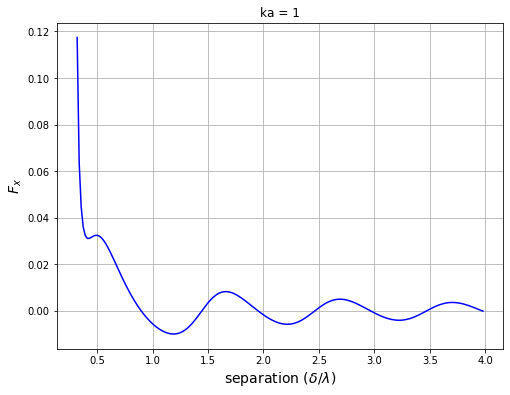

In [22]:
# plot the x-component of the force as a function of δ

plt.rcParams['figure.figsize'] = [8,6]

plt.plot( δ / λ, F3x, 'b-' )
plt.grid()
plt.xlabel( r'separation ($\delta / \lambda$)', fontsize = 14 )
plt.ylabel( r'$F_{x}$', fontsize = 14 )
plt.title(f'ka = {ka}')
plt.show()

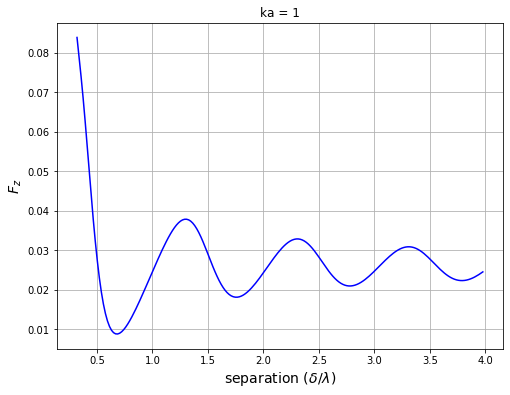

In [21]:
# plot the z-component of the force as a function of δ

plt.rcParams['figure.figsize'] = [8,6]

plt.plot( δ / λ, F3z, 'b-' )
plt.grid()
plt.xlabel( r'separation ($\delta / \lambda$)', fontsize = 14 )
plt.ylabel( r'$F_{z}$', fontsize = 14 )
plt.title(f'ka = {ka}')

plt.show()